In [1]:
%matplotlib inline
from matplotlib import ticker 
littleh=0.7

In [2]:
from galsize_models.measurements import sdss_measurements
from galsize_models.measurements import load_umachine_sdss_with_meert15

full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()
sdss = full_sdss[behroozi_complete & good_profile_mask]

from scipy.stats import binned_statistic
logsm_table = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_table[:-1] + logsm_table[1:])
sdss_r50_table, __, __ = binned_statistic(sdss['sm'], sdss['r50_magr_kpc_meert15'], 
                                            bins=logsm_table, statistic='median')

sdss['median_r50'] = 10**np.interp(sdss['sm'], logsm_mids, np.log10(sdss_r50_table))
sdss['small'] = sdss['r50_magr_kpc_meert15'] < sdss['median_r50']

from slidingpercentile import python_sliding_rank
x = sdss['sm']
y = sdss['r50_magr_kpc_meert15']
window_length = 1001

sliding_rank_orders = python_sliding_rank(x, y, window_length)
size_percentile = (1. + sliding_rank_orders)/float(window_length+1)
sdss['r50_percentile'] = size_percentile

In [3]:
from galsize_models.models import load_orphan_subhalos, moustakas_sham, orphan_selection
subhalos = load_orphan_subhalos()

subhalos['sm'] = moustakas_sham(subhalos['mpeak'], 0.25)

orphan_mask = orphan_selection(subhalos)

mock = subhalos[orphan_mask]

In [4]:
from galsize_models.models import component_size_vs_rhalo

normalization_all = 0.01
alpha_all = 1.
scatter_all = 0.25

mock['r50_nocorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)

mock['r50_maxcorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['vmax_at_mpeak_percentile'])

mock['r50_midcorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['noisy_vmax_at_mpeak_percentile'])


mock['r50_nospl'] = component_size_vs_rhalo(mock['rvir_zpeak_no_splashback'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)


In [5]:
from scipy.stats import binned_statistic 

mock_r50_table, __, __ = binned_statistic(mock['sm'], mock['r50_nocorr'], bins=logsm_table, 
                                         statistic='median')
mock['median_r50'] = np.interp(mock['sm'], logsm_mids, np.log10(mock_r50_table))

mock['r50_mstar'] = 10**np.random.normal(loc=mock['median_r50'], scale=0.2)

In [6]:
logsm_bins = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])


sdss_median_rhalf_table, __, __ = binned_statistic(sdss['sm'], 
                                      sdss['r50_magr_kpc_meert15'], 
                                     bins=logsm_bins, statistic='median')

def frac_surviving_mstar(frac_surviving_dm, a=14.2):
    return 1 - np.exp(-a*frac_surviving_dm)

def frac_r50_reduction(mstar_init, frac_surviving_mstar):
    mstar_final = frac_surviving_mstar*mstar_init
    logsm_init, logsm_final = np.log10([mstar_init, mstar_final])
    initial_r50, final_r50 = np.interp([logsm_init, logsm_final], 
                                          logsm_mids, sdss_median_rhalf_table)
    return final_r50/initial_r50

mock['frac_surviving_dm'] = mock['mvir']/mock['mpeak']
mock['frac_surviving_mstar'] = frac_surviving_mstar(mock['frac_surviving_dm'])
mock['frac_stripped_r50'] = frac_r50_reduction(10**mock['sm'], mock['frac_surviving_mstar'])
mock['r50_mstar_stripping'] = mock['r50_mstar']*mock['frac_stripped_r50']


/Users/aphearin/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2906: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


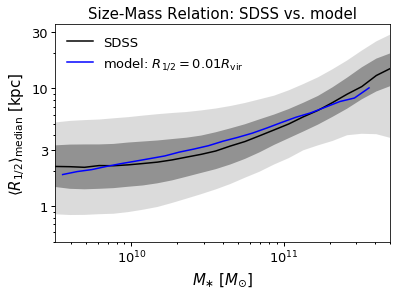

In [7]:
from scipy.special import erf, erfinv
def _percentile_from_z_score(z_score):
    return 0.5*(1 + erf(z_score/np.sqrt(2)))
low_percentile_1sigma, high_percentile_1sigma = _percentile_from_z_score(-1), _percentile_from_z_score(1)
low_percentile_3sigma, high_percentile_3sigma = _percentile_from_z_score(-3), _percentile_from_z_score(3)

logsm_table = np.linspace(9.5, 11.8, 25)
dlogsm = 0.05

r50_table_median = np.zeros_like(logsm_table)
r50_table_1sigma_low = np.zeros_like(logsm_table)
r50_table_1sigma_high = np.zeros_like(logsm_table)
r50_table_3sigma_low = np.zeros_like(logsm_table)
r50_table_3sigma_high = np.zeros_like(logsm_table)

for i, logsm in enumerate(logsm_table):
    mask = np.abs(sdss['sm'] - logsm) < dlogsm
    assert np.count_nonzero(mask) > 100, logsm
    sample_r50 = sdss['r50_magr_kpc_meert15'][mask]
    sample_r50_percentile = sdss['r50_percentile'][mask]
    
    mask_median = np.abs(sample_r50_percentile - 0.5) < 0.01
    r50_table_median[i] = np.median(sample_r50[mask_median])
    
    mask_p50 = (sample_r50_percentile > 0.25) & (sample_r50_percentile < 0.75)
    r50_table_1sigma_low[i] = np.min(sample_r50[mask_p50])
    r50_table_1sigma_high[i] = np.max(sample_r50[mask_p50])

    mask_p90 = (sample_r50_percentile > 0.05) & (sample_r50_percentile < 0.95)
    r50_table_3sigma_low[i] = np.min(sample_r50[mask_p90])
    r50_table_3sigma_high[i] = np.max(sample_r50[mask_p90])

from scipy.stats import binned_statistic
mock_r50_median, __, __ = binned_statistic(
            mock['sm'], mock['r50_nocorr'], bins=logsm_table, statistic='median')
logsm_mids = 0.5*(logsm_table[:-1] + logsm_table[1:])

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

xmin, xmax = 10**9.5, 5e11
ymin, ymax = 0.5, 35
_xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
_ylabel = r'$\langle R_{1/2} \rangle_{\rm median}$ $[{\rm kpc}]$'
xlim = ax.set_xlim(xmin, xmax)
ylim = ax.set_ylim(ymin, ymax)
__=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
__=ax.set_yticks((1, 3, 10, 30))

ylabel=ax.set_ylabel(_ylabel)
xlabel=ax.set_xlabel(_xlabel)
title=ax.set_title(r'Size-Mass Relation: SDSS vs. model')

__=ax.plot(10**logsm_table, r50_table_median, color='k', label='SDSS')
__=ax.plot(10**logsm_mids[:-2], mock_r50_median[:-2], color='blue', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')

y1, y2 = r50_table_3sigma_low, r50_table_3sigma_high
from scipy.signal import savgol_filter
y1_smooth = savgol_filter(y1, 7, 3)
y2_smooth = savgol_filter(y2, 7, 3)
# __=ax.fill_between(10**logsm_table, y1, y2, facecolor='lightgray', alpha=0.8)
__=ax.fill_between(10**logsm_table, y1_smooth, y2_smooth, facecolor='lightgray', alpha=0.8)

y1, y2 = r50_table_1sigma_low, r50_table_1sigma_high
y1_smooth = savgol_filter(y1, 7, 3)
y2_smooth = savgol_filter(y2, 7, 3)
# __=ax.fill_between(10**logsm_table, y1, y2, facecolor='gray', alpha=0.8)
__=ax.fill_between(10**logsm_table, y1_smooth, y2_smooth, facecolor='gray', alpha=0.8)


leg = ax.legend()

figname = 'rvir_only_rhalf_vs_mstar_sham_model.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [8]:
from galsize_models.measurements import single_component_clustering

In [9]:
mock['r50'] = mock['r50_nocorr']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_nocorr, wp_all_mock_sm9p75_nocorr, wp_large_mock_sm9p75_nocorr = _x[1]
wp_small_mock_sm10p25_nocorr, wp_all_mock_sm10p25_nocorr, wp_large_mock_sm10p25_nocorr = _x[2]
wp_small_mock_sm10p75_nocorr, wp_all_mock_sm10p75_nocorr, wp_large_mock_sm10p75_nocorr = _x[3]
wp_small_mock_sm11p0_nocorr, wp_all_mock_sm11p0_nocorr, wp_large_mock_sm11p0_nocorr = _x[4]
wp_small_mock_sm11p25_nocorr, wp_all_mock_sm11p25_nocorr, wp_large_mock_sm11p25_nocorr = _x[5]


In [10]:
mock['r50'] = mock['r50_midcorr']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_midcorr, wp_all_mock_sm9p75_midcorr, wp_large_mock_sm9p75_midcorr = _x[1]
wp_small_mock_sm10p25_midcorr, wp_all_mock_sm10p25_midcorr, wp_large_mock_sm10p25_midcorr = _x[2]
wp_small_mock_sm10p75_midcorr, wp_all_mock_sm10p75_midcorr, wp_large_mock_sm10p75_midcorr = _x[3]
wp_small_mock_sm11p0_midcorr, wp_all_mock_sm11p0_midcorr, wp_large_mock_sm11p0_midcorr = _x[4]
wp_small_mock_sm11p25_midcorr, wp_all_mock_sm11p25_midcorr, wp_large_mock_sm11p25_midcorr = _x[5]


In [11]:
mock['r50'] = mock['r50_mstar']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_mstar, wp_all_mock_sm9p75_mstar, wp_large_mock_sm9p75_mstar = _x[1]
wp_small_mock_sm10p25_mstar, wp_all_mock_sm10p25_mstar, wp_large_mock_sm10p25_mstar = _x[2]
wp_small_mock_sm10p75_mstar, wp_all_mock_sm10p75_mstar, wp_large_mock_sm10p75_mstar = _x[3]
wp_small_mock_sm11p0_mstar, wp_all_mock_sm11p0_mstar, wp_large_mock_sm11p0_mstar = _x[4]
wp_small_mock_sm11p25_mstar, wp_all_mock_sm11p25_mstar, wp_large_mock_sm11p25_mstar = _x[5]


In [12]:
mock['r50'] = mock['r50_nospl']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_nospl, wp_all_mock_sm9p75_nospl, wp_large_mock_sm9p75_nospl = _x[1]
wp_small_mock_sm10p25_nospl, wp_all_mock_sm10p25_nospl, wp_large_mock_sm10p25_nospl = _x[2]
wp_small_mock_sm10p75_nospl, wp_all_mock_sm10p75_nospl, wp_large_mock_sm10p75_nospl = _x[3]
wp_small_mock_sm11p0_nospl, wp_all_mock_sm11p0_nospl, wp_large_mock_sm11p0_nospl = _x[4]
wp_small_mock_sm11p25_nospl, wp_all_mock_sm11p25_nospl, wp_large_mock_sm11p25_nospl = _x[5]


In [13]:
mock['r50'] = mock['r50_nocorr']

median_rhalf_mock, __, __ = binned_statistic(mock['sm'][~mock['orphan']], 
                        mock['r50'][~mock['orphan']], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock[~mock['orphan']])
rp_mids = _x[0]
wp_small_mock_sm9p75_noorphan, wp_all_mock_sm9p75_noorphan, wp_large_mock_sm9p75_noorphan = _x[1]
wp_small_mock_sm10p25_noorphan, wp_all_mock_sm10p25_noorphan, wp_large_mock_sm10p25_noorphan = _x[2]
wp_small_mock_sm10p75_noorphan, wp_all_mock_sm10p75_noorphan, wp_large_mock_sm10p75_noorphan = _x[3]
wp_small_mock_sm11p0_noorphan, wp_all_mock_sm11p0_noorphan, wp_large_mock_sm11p0_noorphan = _x[4]
wp_small_mock_sm11p25_noorphan, wp_all_mock_sm11p25_noorphan, wp_large_mock_sm11p25_noorphan = _x[5]


In [15]:
from galsize_models.models import random_orphan_selection

num_orphans = np.count_nonzero(mock['orphan'])
random_orphan_mask = random_orphan_selection(subhalos, num_orphans)
mock_random_orphans = subhalos[random_orphan_mask]

normalization_all = 0.01
alpha_all = 1.
scatter_all = 0.25

mock_random_orphans['r50_nocorr'] = component_size_vs_rhalo(mock_random_orphans['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)

mock_random_orphans['r50'] = mock_random_orphans['r50_nocorr']
median_rhalf_mock_random_orphans, __, __ = binned_statistic(mock_random_orphans['sm'], mock_random_orphans['r50'], bins=logsm_table, 
                                            statistic='median')

mock_random_orphans['r50_median'] = np.interp(mock_random_orphans['sm'], logsm_mids, median_rhalf_mock_random_orphans)

_x = single_component_clustering(mock_random_orphans)
rp_mids = _x[0]
wp_small_mock_sm9p75_random_orphans, wp_all_mock_sm9p75_random_orphans, wp_large_mock_sm9p75_random_orphans = _x[1]
wp_small_mock_sm10p25_random_orphans, wp_all_mock_sm10p25_random_orphans, wp_large_mock_sm10p25_random_orphans = _x[2]
wp_small_mock_sm10p75_random_orphans, wp_all_mock_sm10p75_random_orphans, wp_large_mock_sm10p75_random_orphans = _x[3]
wp_small_mock_sm11p0_random_orphans, wp_all_mock_sm11p0_random_orphans, wp_large_mock_sm11p0_random_orphans = _x[4]
wp_small_mock_sm11p25_random_orphans, wp_all_mock_sm11p25_random_orphans, wp_large_mock_sm11p25_random_orphans = _x[5]

In [16]:
mock['r50'] = mock['r50_mstar_stripping']

median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_mstar_stripping, wp_all_mock_sm9p75_mstar_stripping, wp_large_mock_sm9p75_mstar_stripping = _x[1]
wp_small_mock_sm10p25_mstar_stripping, wp_all_mock_sm10p25_mstar_stripping, wp_large_mock_sm10p25_mstar_stripping = _x[2]
wp_small_mock_sm10p75_mstar_stripping, wp_all_mock_sm10p75_mstar_stripping, wp_large_mock_sm10p75_mstar_stripping = _x[3]
wp_small_mock_sm11p0_mstar_stripping, wp_all_mock_sm11p0_mstar_stripping, wp_large_mock_sm11p0_mstar_stripping = _x[4]
wp_small_mock_sm11p25_mstar_stripping, wp_all_mock_sm11p25_mstar_stripping, wp_large_mock_sm11p25_mstar_stripping = _x[5]


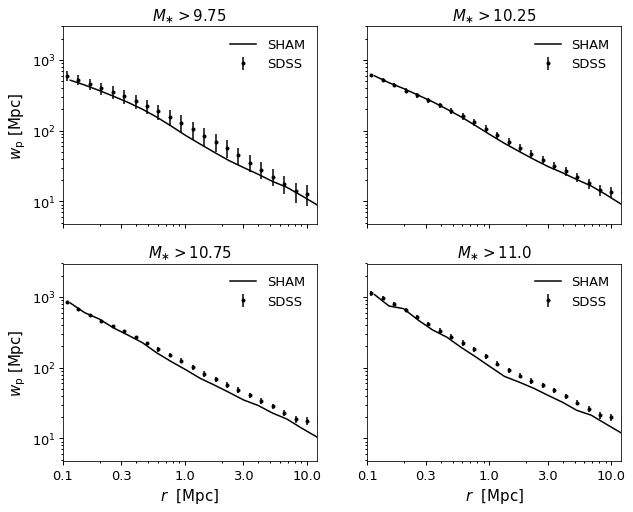

In [32]:
from galsize_models.measurements import sdss_measurements
littleh = 0.7
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 12)

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='k', label=r'SDSS')


ifirst=0
__=ax1.plot(rp_mids, wp_all_mock_sm9p75_nocorr, color='k', label='SHAM')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_nocorr, color='k', label='SHAM')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_nocorr, color='k', label='SHAM')
__=ax4.plot(rp_mids[ifirst:], wp_all_mock_sm11p0_nocorr[ifirst:], color='k', label='SHAM')

__=ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

__=ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax3.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax4.set_xticks((0.1, 0.3, 1, 3, 10))

for ax in (ax1, ax2, ax3, ax4):
    __=ax.legend()
    
figname = 'baseline_sham.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


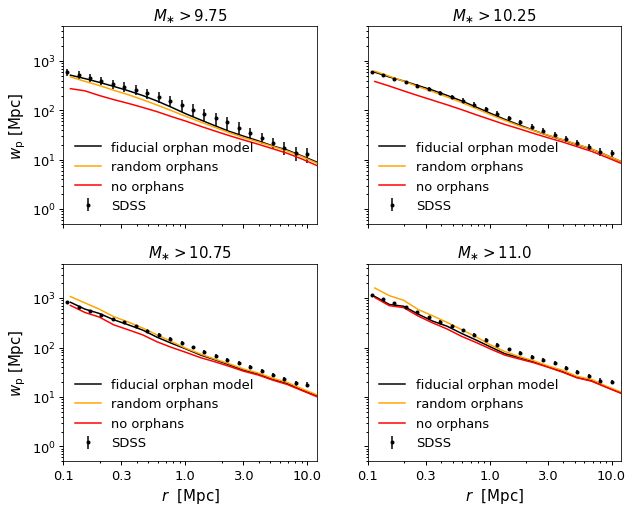

In [40]:
from galsize_models.measurements import sdss_measurements
littleh = 0.7
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 12)
    ylim = ax.set_ylim(0.5, 5e3)

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='k', label=r'SDSS')


ifirst=0
__=ax1.plot(rp_mids, wp_all_mock_sm9p75_nocorr, color='k', label='fiducial orphan model')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_nocorr, color='k', label='fiducial orphan model')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_nocorr, color='k', label='fiducial orphan model')
__=ax4.plot(rp_mids, wp_all_mock_sm11p0_nocorr, color='k', label='fiducial orphan model')

__=ax1.plot(rp_mids, wp_all_mock_sm9p75_random_orphans, color='orange', label='random orphans')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_random_orphans, color='orange', label='random orphans')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_random_orphans, color='orange', label='random orphans')
__=ax4.plot(rp_mids, wp_all_mock_sm11p0_random_orphans, color='orange', label='random orphans')

__=ax1.plot(rp_mids, wp_all_mock_sm9p75_noorphan, color='red', label='no orphans')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_noorphan, color='red', label='no orphans')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_noorphan, color='red', label='no orphans')
__=ax4.plot(rp_mids, wp_all_mock_sm11p0_noorphan, color='red', label='no orphans')

__=ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

__=ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax3.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax4.set_xticks((0.1, 0.3, 1, 3, 10))

for ax in (ax1, ax2, ax3, ax4):
    __=ax.legend()
    
figname = 'baseline_sham_orphans.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


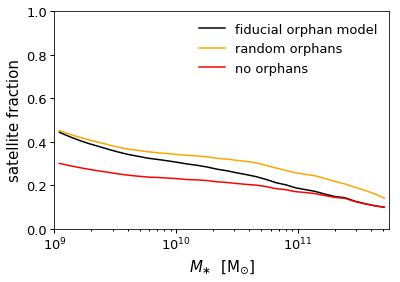

In [61]:
from scipy.stats import binned_statistic
logsm_bins_fsat = np.linspace(9, 11.75, 35)
logsm_mids_fsat = 0.5*(logsm_bins_fsat[:-1] + logsm_bins_fsat[1:])
mean_fsat_fiducial, __, __ = binned_statistic(mock['sm'], mock['upid']!=-1, 
                                              bins=logsm_bins_fsat)

mask = ~mock['orphan']
mean_fsat_noorphan, __, __ = binned_statistic(mock['sm'][mask], mock['upid'][mask]!=-1, 
                                              bins=logsm_bins_fsat)

mean_fsat_random_orphan, __, __ = binned_statistic(mock_random_orphans['sm'], 
                                                   mock_random_orphans['upid']!=-1, 
                                              bins=logsm_bins_fsat)

from scipy.signal import savgol_filter
mean_fsat_fiducial_smooth = savgol_filter(mean_fsat_fiducial, 7, 3)
mean_fsat_noorphan_smooth = savgol_filter(mean_fsat_noorphan, 7, 3)
mean_fsat_random_orphan_smooth = savgol_filter(mean_fsat_random_orphan, 7, 3)

fig, ax = plt.subplots(1, 1)

xscale = ax.set_xscale('log')
xlim = ax.set_xlim(10**9., 10**11.75)
ylim = ax.set_ylim(0, 1)
__=ax.plot(10**logsm_mids_fsat, mean_fsat_fiducial_smooth, 
           color='k', label='fiducial orphan model')
__=ax.plot(10**logsm_mids_fsat, mean_fsat_random_orphan_smooth, 
           color='orange', label='random orphans')
__=ax.plot(10**logsm_mids_fsat, mean_fsat_noorphan_smooth, 
           color='red', label='no orphans')

__=ax.legend()

xlabel = ax.set_xlabel(r'$M_{\ast}$  $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'satellite fraction')

figname = 'orphan_satellite_fraction.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


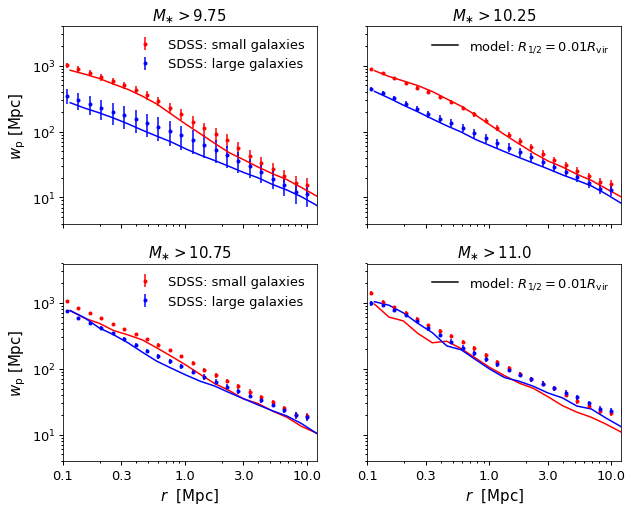

In [62]:
from galsize_models.measurements import sdss_measurements
littleh = 0.7
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 12)

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='red', label=r'SDSS: small galaxies')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='red')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='red', label=r'SDSS: small galaxies')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0_small[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='red')

__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='blue', label=r'SDSS: large galaxies')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='blue')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='blue', label=r'SDSS: large galaxies')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0_large[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='blue')

ifirst=0
__=ax1.plot(rp_mids, wp_small_mock_sm9p75_nocorr, color='red')
__=ax2.plot(rp_mids, wp_small_mock_sm10p25_nocorr, color='red', 
            label=r'model: $R_{1/2}=0.01R_{\rm vir}$')
__=ax3.plot(rp_mids, wp_small_mock_sm10p75_nocorr, color='red')
__=ax4.plot(rp_mids[ifirst:], wp_small_mock_sm11p0_nocorr[ifirst:], color='red', 
            label=r'model: $R_{1/2}=0.01R_{\rm vir}$')

__=ax1.plot(rp_mids, wp_large_mock_sm9p75_nocorr, color='blue')
__=ax2.plot(rp_mids, wp_large_mock_sm10p25_nocorr, color='blue')
__=ax3.plot(rp_mids, wp_large_mock_sm10p75_nocorr, color='blue')
__=ax4.plot(rp_mids[ifirst:], wp_large_mock_sm11p0_nocorr[ifirst:], color='blue')

__=ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

__=ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax3.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax4.set_xticks((0.1, 0.3, 1, 3, 10))

leg1 = ax1.legend()
leg2 = ax2.legend()
leg3 = ax3.legend()
leg4 = ax4.legend()
leg2.legendHandles[0].set_color('k')
leg4.legendHandles[0].set_color('k')

figname = 'rvir_only_wp_large_small_absolute.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


In [63]:
fracdiff_sm9p75_midcorr = (wp_large_mock_sm9p75_midcorr-wp_small_mock_sm9p75_midcorr)/wp_all_mock_sm9p75_midcorr
fracdiff_sm10p25_midcorr = (wp_large_mock_sm10p25_midcorr-wp_small_mock_sm10p25_midcorr)/wp_all_mock_sm10p25_midcorr
fracdiff_sm10p75_midcorr = (wp_large_mock_sm10p75_midcorr-wp_small_mock_sm10p75_midcorr)/wp_all_mock_sm10p75_midcorr
fracdiff_sm11p0_midcorr = (wp_large_mock_sm11p0_midcorr-wp_small_mock_sm11p0_midcorr)/wp_all_mock_sm11p0_midcorr
fracdiff_sm11p25_midcorr = (wp_large_mock_sm11p25_midcorr-wp_small_mock_sm11p25_midcorr)/wp_all_mock_sm11p25_midcorr

In [64]:
fracdiff_sm9p75_nocorr = (wp_large_mock_sm9p75_nocorr-wp_small_mock_sm9p75_nocorr)/wp_all_mock_sm9p75_nocorr
fracdiff_sm10p25_nocorr = (wp_large_mock_sm10p25_nocorr-wp_small_mock_sm10p25_nocorr)/wp_all_mock_sm10p25_nocorr
fracdiff_sm10p75_nocorr = (wp_large_mock_sm10p75_nocorr-wp_small_mock_sm10p75_nocorr)/wp_all_mock_sm10p75_nocorr
fracdiff_sm11p0_nocorr = (wp_large_mock_sm11p0_nocorr-wp_small_mock_sm11p0_nocorr)/wp_all_mock_sm11p0_nocorr
fracdiff_sm11p25_nocorr = (wp_large_mock_sm11p25_nocorr-wp_small_mock_sm11p25_nocorr)/wp_all_mock_sm11p25_nocorr

In [65]:
fracdiff_sm9p75_mstar = (wp_large_mock_sm9p75_mstar-wp_small_mock_sm9p75_mstar)/wp_all_mock_sm9p75_mstar
fracdiff_sm10p25_mstar = (wp_large_mock_sm10p25_mstar-wp_small_mock_sm10p25_mstar)/wp_all_mock_sm10p25_mstar
fracdiff_sm10p75_mstar = (wp_large_mock_sm10p75_mstar-wp_small_mock_sm10p75_mstar)/wp_all_mock_sm10p75_mstar
fracdiff_sm11p0_mstar = (wp_large_mock_sm11p0_mstar-wp_small_mock_sm11p0_mstar)/wp_all_mock_sm11p0_mstar
fracdiff_sm11p25_mstar = (wp_large_mock_sm11p25_mstar-wp_small_mock_sm11p25_mstar)/wp_all_mock_sm11p25_mstar

In [66]:
fracdiff_sm9p75_nospl = (wp_large_mock_sm9p75_nospl-wp_small_mock_sm9p75_nospl)/wp_all_mock_sm9p75_nospl
fracdiff_sm10p25_nospl = (wp_large_mock_sm10p25_nospl-wp_small_mock_sm10p25_nospl)/wp_all_mock_sm10p25_nospl
fracdiff_sm10p75_nospl = (wp_large_mock_sm10p75_nospl-wp_small_mock_sm10p75_nospl)/wp_all_mock_sm10p75_nospl
fracdiff_sm11p0_nospl = (wp_large_mock_sm11p0_nospl-wp_small_mock_sm11p0_nospl)/wp_all_mock_sm11p0_nospl
fracdiff_sm11p25_nospl = (wp_large_mock_sm11p25_nospl-wp_small_mock_sm11p25_nospl)/wp_all_mock_sm11p25_nospl

In [67]:
fracdiff_sm9p75_noorphan = (wp_large_mock_sm9p75_noorphan-wp_small_mock_sm9p75_noorphan)/wp_all_mock_sm9p75_noorphan
fracdiff_sm10p25_noorphan = (wp_large_mock_sm10p25_noorphan-wp_small_mock_sm10p25_noorphan)/wp_all_mock_sm10p25_noorphan
fracdiff_sm10p75_noorphan = (wp_large_mock_sm10p75_noorphan-wp_small_mock_sm10p75_noorphan)/wp_all_mock_sm10p75_noorphan
fracdiff_sm11p0_noorphan = (wp_large_mock_sm11p0_noorphan-wp_small_mock_sm11p0_noorphan)/wp_all_mock_sm11p0_noorphan
fracdiff_sm11p25_noorphan = (wp_large_mock_sm11p25_noorphan-wp_small_mock_sm11p25_noorphan)/wp_all_mock_sm11p25_noorphan

In [68]:
fracdiff_sm9p75_mstar_stripping = (wp_large_mock_sm9p75_mstar_stripping-wp_small_mock_sm9p75_mstar_stripping)/wp_all_mock_sm9p75_mstar_stripping
fracdiff_sm10p25_mstar_stripping = (wp_large_mock_sm10p25_mstar_stripping-wp_small_mock_sm10p25_mstar_stripping)/wp_all_mock_sm10p25_mstar_stripping
fracdiff_sm10p75_mstar_stripping = (wp_large_mock_sm10p75_mstar_stripping-wp_small_mock_sm10p75_mstar_stripping)/wp_all_mock_sm10p75_mstar_stripping
fracdiff_sm11p0_mstar_stripping = (wp_large_mock_sm11p0_mstar_stripping-wp_small_mock_sm11p0_mstar_stripping)/wp_all_mock_sm11p0_mstar_stripping
fracdiff_sm11p25_mstar_stripping = (wp_large_mock_sm11p25_mstar_stripping-wp_small_mock_sm11p25_mstar_stripping)/wp_all_mock_sm11p25_mstar_stripping

In [69]:
fracdiff_sm9p75_random_orphans = (wp_large_mock_sm9p75_random_orphans-wp_small_mock_sm9p75_random_orphans)/wp_all_mock_sm9p75_random_orphans
fracdiff_sm10p25_random_orphans = (wp_large_mock_sm10p25_random_orphans-wp_small_mock_sm10p25_random_orphans)/wp_all_mock_sm10p25_random_orphans
fracdiff_sm10p75_random_orphans = (wp_large_mock_sm10p75_random_orphans-wp_small_mock_sm10p75_random_orphans)/wp_all_mock_sm10p75_random_orphans
fracdiff_sm11p0_random_orphans = (wp_large_mock_sm11p0_random_orphans-wp_small_mock_sm11p0_random_orphans)/wp_all_mock_sm11p0_random_orphans
fracdiff_sm11p25_random_orphans = (wp_large_mock_sm11p25_random_orphans-wp_small_mock_sm11p25_random_orphans)/wp_all_mock_sm11p25_random_orphans

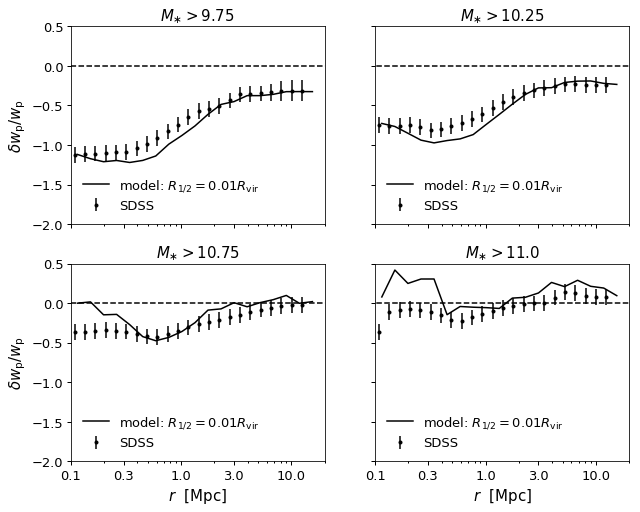

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    xscale = ax.set_xscale('log')
    xlim = ax.set_xlim(0.1, 20)
    ylim = ax.set_ylim(-2, 0.5)
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
ylabel3 = ax3.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, sdss_measurements.fracdiff_sm9p75_mpajhu, 
                sdss_measurements.fracdiff_sm9p75_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax2.errorbar(x, sdss_measurements.fracdiff_sm10p25_mpajhu, 
                sdss_measurements.fracdiff_sm10p25_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax3.errorbar(x, sdss_measurements.fracdiff_sm10p75_mpajhu, 
                sdss_measurements.fracdiff_sm10p75_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax4.errorbar(x[ifirst:], sdss_measurements.fracdiff_sm11p0_mpajhu[ifirst:], 
                sdss_measurements.fracdiff_sm11p0_mpajhu_err[ifirst:], 
               fmt='.', color='k', label=r'SDSS')

ifirst=0
__=ax1.plot(rp_mids, fracdiff_sm9p75_nocorr, color='k', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')
__=ax2.plot(rp_mids, fracdiff_sm10p25_nocorr, color='k', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')
__=ax3.plot(rp_mids, fracdiff_sm10p75_nocorr, color='k', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_nocorr[ifirst:], color='k', 
            label=r'model: $R_{1/2}=0.01R_{\rm vir}$')

ax3.set_xticks((0.1, 0.3, 1, 3, 10))
ax4.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)
ax4.set_yticklabels(empty_string_labels)

legend = ax1.legend()
legend = ax2.legend()
legend = ax3.legend()
legend = ax4.legend()

figname = 'rvir_only_wp_ratios.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


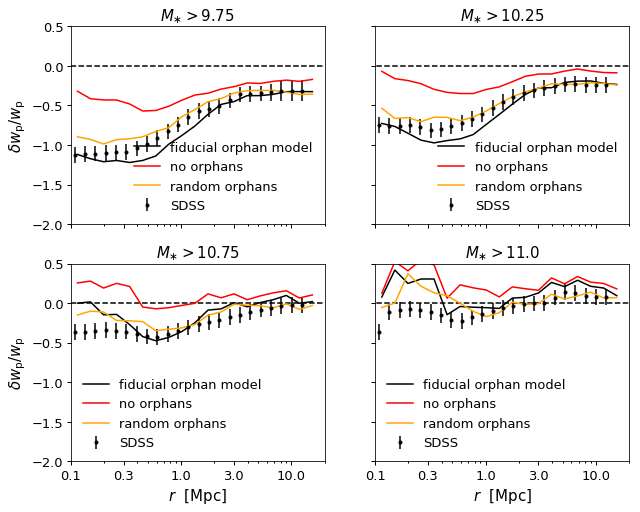

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    xscale = ax.set_xscale('log')
    xlim = ax.set_xlim(0.1, 20)
    ylim = ax.set_ylim(-2, 0.5)
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
ylabel3 = ax3.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, sdss_measurements.fracdiff_sm9p75_mpajhu, 
                sdss_measurements.fracdiff_sm9p75_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax2.errorbar(x, sdss_measurements.fracdiff_sm10p25_mpajhu, 
                sdss_measurements.fracdiff_sm10p25_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax3.errorbar(x, sdss_measurements.fracdiff_sm10p75_mpajhu, 
                sdss_measurements.fracdiff_sm10p75_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax4.errorbar(x[ifirst:], sdss_measurements.fracdiff_sm11p0_mpajhu[ifirst:], 
                sdss_measurements.fracdiff_sm11p0_mpajhu_err[ifirst:], 
               fmt='.', color='k', label=r'SDSS')

ifirst=0
__=ax1.plot(rp_mids, fracdiff_sm9p75_nocorr, color='k', 
           label=r'fiducial orphan model')
__=ax2.plot(rp_mids, fracdiff_sm10p25_nocorr, color='k', 
           label=r'fiducial orphan model')
__=ax3.plot(rp_mids, fracdiff_sm10p75_nocorr, color='k', 
           label=r'fiducial orphan model')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_nocorr[ifirst:], color='k', 
           label=r'fiducial orphan model')

__=ax1.plot(rp_mids, fracdiff_sm9p75_noorphan, color='red', 
           label=r'no orphans')
__=ax2.plot(rp_mids, fracdiff_sm10p25_noorphan, color='red', 
           label=r'no orphans')
__=ax3.plot(rp_mids, fracdiff_sm10p75_noorphan, color='red', 
           label=r'no orphans')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_noorphan[ifirst:], color='red', 
           label=r'no orphans')

__=ax1.plot(rp_mids, fracdiff_sm9p75_random_orphans, color='orange', 
           label=r'random orphans')
__=ax2.plot(rp_mids, fracdiff_sm10p25_random_orphans, color='orange', 
           label=r'random orphans')
__=ax3.plot(rp_mids, fracdiff_sm10p75_random_orphans, color='orange', 
           label=r'random orphans')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_random_orphans[ifirst:], color='orange', 
           label=r'random orphans')

ax3.set_xticks((0.1, 0.3, 1, 3, 10))
ax4.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)
ax4.set_yticklabels(empty_string_labels)

legend = ax1.legend()
legend = ax2.legend()
legend = ax3.legend()
legend = ax4.legend()

figname = 'clustering_ratios_orphan_impact.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


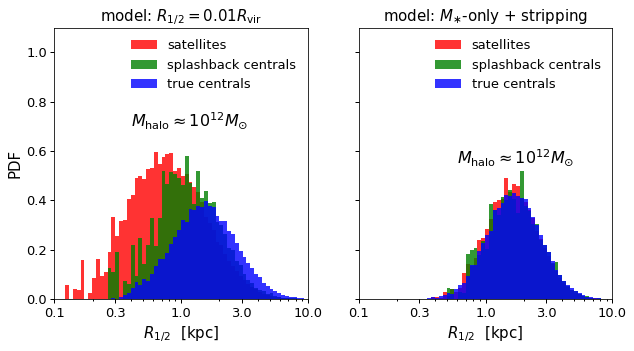

In [72]:
mask = (mock['mpeak'] > 10**11.9) & (mock['mpeak'] < 10**12.25)
sample = mock[mask]

truecen_mask = (sample['first_acc_scale'] > 1) & (sample['upid']==-1)
splcen_mask = (sample['first_acc_scale'] < 0.8) & (sample['upid']==-1)
sat_mask = sample['upid']!=-1

truecens = sample[truecen_mask]
splcens = sample[splcen_mask]
sats = sample[sat_mask]

r50_bins = np.logspace(-1.25, 1, 75)


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
xscale1 = ax1.set_xscale('log')
xscale2 = ax2.set_xscale('log')

__=ax1.hist(sats['r50_nocorr'], bins=r50_bins, normed=True, 
           alpha=0.8, color='red', label=r'satellites')
__=ax1.hist(splcens['r50_nocorr'], bins=r50_bins, normed=True, 
           alpha=0.8, color='green', label=r'splashback centrals')
__=ax1.hist(truecens['r50_nocorr'], bins=r50_bins, normed=True, 
           alpha=0.8, color='blue', label=r'true centrals')

__=ax2.hist(sats['r50_mstar_stripping'], bins=r50_bins, normed=True, 
           alpha=0.8, color='red', label='satellites')
__=ax2.hist(splcens['r50_mstar_stripping'], bins=r50_bins, normed=True, 
           alpha=0.8, color='green', label='splashback centrals')
__=ax2.hist(truecens['r50_mstar_stripping'], bins=r50_bins, normed=True, 
           alpha=0.8, color='blue', label='true centrals')


legend1 = ax1.legend()
legend2 = ax2.legend()

ylabel1 = ax1.set_ylabel(r'PDF')
xlabel1 = ax1.set_xlabel(r'$R_{1/2}$  $[{\rm kpc}]$')
# ylabel2 = ax2.set_ylabel(r'PDF')
xlabel2 = ax2.set_xlabel(r'$R_{1/2}$  $[{\rm kpc}]$')

title1 = ax1.set_title(r'model: $R_{1/2}=0.01R_{\rm vir}$')
title2 = ax2.set_title(
    r'model: $M_{\ast}$-only + stripping')

xlim1 = ax1.set_xlim(0.1, 10)
ylim1 = ax1.set_ylim(0, 1.1)
xlim2 = ax2.set_xlim(0.1, 10)
ylim2 = ax2.set_ylim(0, 1.1)

ax1.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax2.set_xticks((0.1, 0.3, 1, 3, 10))
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(ticker.NullFormatter())

a, b = 0.4, 0.7
__=ax1.annotate(r'$M_{\rm halo}\approx10^{12}M_{\odot}$', 
               xy=(a, b), xytext=(a, b), size=16)
__=ax2.annotate(r'$M_{\rm halo}\approx10^{12}M_{\odot}$', 
               xy=(a, b), xytext=(0.6, 0.55), size=16)

figname = 'rvir_only_vs_stripping_cen_sat_sizes.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

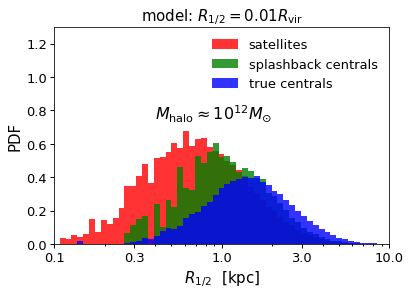

In [73]:
mask = (mock['mpeak'] > 10**11.8) & (mock['mpeak'] < 10**12.25)
sample = mock[mask]

truecen_mask = (sample['first_acc_scale'] > 1) & (sample['upid']==-1)
splcen_mask = (sample['first_acc_scale'] < 0.8) & (sample['upid']==-1)
sat_mask = sample['upid']!=-1

truecens = sample[truecen_mask]
splcens = sample[splcen_mask]
sats = sample[sat_mask]

r50_bins = np.logspace(-1.25, 1, 65)


fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

__=ax.hist(sats['r50_nocorr'], bins=r50_bins, normed=True, 
           alpha=0.8, color='red', label=r'satellites')
__=ax.hist(splcens['r50_nocorr'], bins=r50_bins, normed=True, 
           alpha=0.8, color='green', label=r'splashback centrals')
__=ax.hist(truecens['r50_nocorr'], bins=r50_bins, normed=True, 
           alpha=0.8, color='blue', label=r'true centrals')

legend = ax.legend()

ylabel = ax.set_ylabel(r'PDF')
xlabel = ax.set_xlabel(r'$R_{1/2}$  $[{\rm kpc}]$')

title = ax.set_title(r'model: $R_{1/2}=0.01R_{\rm vir}$')

xlim = ax.set_xlim(0.1, 10)
ylim = ax.set_ylim(0, 1.3)

ax.set_xticks((0.1, 0.3, 1, 3, 10))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

a, b = 0.4, 0.75
__=ax.annotate(r'$M_{\rm halo}\approx10^{12}M_{\odot}$', 
               xy=(a, b), xytext=(a, b), size=16)

figname = 'rvir_only_cen_sat_sizes.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

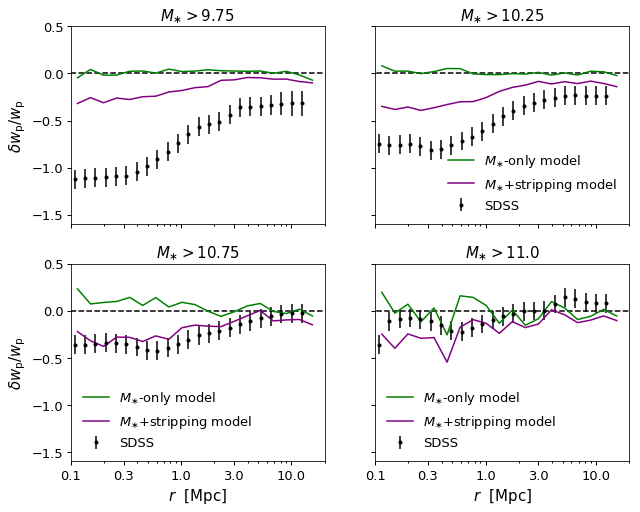

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    xscale = ax.set_xscale('log')
    xlim = ax.set_xlim(0.1, 20)
    ylim = ax.set_ylim(-1.6, 0.5)
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
ylabel3 = ax3.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, sdss_measurements.fracdiff_sm9p75_mpajhu, 
                sdss_measurements.fracdiff_sm9p75_mpajhu_err, 
               fmt='.', color='k')
__=ax2.errorbar(x, sdss_measurements.fracdiff_sm10p25_mpajhu, 
                sdss_measurements.fracdiff_sm10p25_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax3.errorbar(x, sdss_measurements.fracdiff_sm10p75_mpajhu, 
                sdss_measurements.fracdiff_sm10p75_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax4.errorbar(x[ifirst:], sdss_measurements.fracdiff_sm11p0_mpajhu[ifirst:], 
                sdss_measurements.fracdiff_sm11p0_mpajhu_err[ifirst:], 
               fmt='.', color='k', label=r'SDSS')

ifirst=0
__=ax1.plot(rp_mids, fracdiff_sm9p75_mstar, color='green')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mstar, color='green', 
           label=r'$M_{\ast}$-only model')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mstar, color='green', 
           label=r'$M_{\ast}$-only model')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_mstar[ifirst:], color='green', 
           label=r'$M_{\ast}$-only model')

__=ax1.plot(rp_mids, fracdiff_sm9p75_mstar_stripping, color='purple')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mstar_stripping, color='purple', 
           label=r'$M_{\ast}$+stripping model')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mstar_stripping, color='purple', 
           label=r'$M_{\ast}$+stripping model')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_mstar_stripping[ifirst:], color='purple', 
           label=r'$M_{\ast}$+stripping model')

ax3.set_xticks((0.1, 0.3, 1, 3, 10))
ax4.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)
ax4.set_yticklabels(empty_string_labels)

legend = ax1.legend()
legend = ax2.legend()
legend = ax3.legend()
legend = ax4.legend()

figname = 'alt_model_wp_ratios.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


In [75]:
from halotools.mock_observables import return_xyz_formatted_array, delta_sigma
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
particles = halocat.ptcl_table

particle_pos = return_xyz_formatted_array(particles['x'], particles['y'], particles['z'])

total_num_ptcl_in_snapshot = halocat.num_ptcl_per_dim**3
downsampling_factor = total_num_ptcl_in_snapshot/float(len(particles))
particle_masses = halocat.particle_mass

sm_mask = (mock['sm'] > 9.75) & (mock['sm']<10.25)
all_galaxy_pos = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=sm_mask)
small_sm_mask = sm_mask * ((mock['r50_nocorr'] < mock['r50_median']))
small_galaxy_pos = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=small_sm_mask)
large_sm_mask = sm_mask * ((mock['r50_nocorr'] >= mock['r50_median']))
large_galaxy_pos = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=large_sm_mask)
print(small_galaxy_pos.shape, large_galaxy_pos.shape)

((51390, 3), (52008, 3))


In [76]:
rp_bins = np.logspace(-1, 1.25, 10)
period = halocat.Lbox
rp_mids, ds_small = delta_sigma(small_galaxy_pos, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
rp_mids, ds_large = delta_sigma(large_galaxy_pos, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
ds_small = ds_small/1e12
ds_large = ds_large/1e12

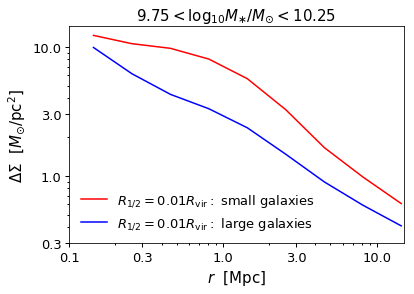

In [77]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.plot(rp_mids, ds_small, color='red', 
           label=r'$R_{1/2}=0.01R_{\rm vir}:$ small galaxies')
__=ax.plot(rp_mids, ds_large, color='blue', 
           label=r'$R_{1/2}=0.01R_{\rm vir}:$ large galaxies')

legend = ax.legend()

ax.set_xticks((0.1, 0.3, 1, 3, 10))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_yticks((0.3, 1, 3, 10))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
xlim = ax.set_xlim(0.1, 15)

ylabel = ax.set_ylabel(r'$\Delta\Sigma$  $[M_{\odot}/{\rm pc^2}]$')
xlabel = ax.set_xlabel(r'$r$  $[{\rm Mpc}]$')
title = ax.set_title(r'$9.75 < \log_{10}M_{\ast}/M_{\odot} < 10.25$')

figname = 'rvir_only_lensing_prediction.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

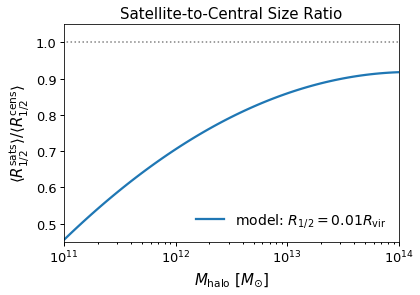

In [78]:
log_mpeak_bins = np.linspace(11., 14.25, 35)
satmask = mock['upid'] != -1
cenmask = ~satmask & (mock['first_acc_scale']>1)
from scipy.stats import binned_statistic

median_size_sats, __, __ = binned_statistic(
    np.log10(mock['mpeak'][satmask]), mock['r50_nocorr'][satmask], 
                                   bins=log_mpeak_bins)
median_size_cens, __, __ = binned_statistic(
    np.log10(mock['mpeak'][cenmask]), mock['r50_nocorr'][cenmask], 
                                   bins=log_mpeak_bins)
log_mpeak_mids = 0.5*(log_mpeak_bins[:-1] + log_mpeak_bins[1:])

size_ratio = median_size_sats/median_size_cens

from scipy.signal import savgol_filter
from scipy.signal import medfilt
smoothed_size_ratio = medfilt(size_ratio, 5)
smoothed_size_ratio = savgol_filter(smoothed_size_ratio, 5, 3)
p = np.polyfit(log_mpeak_mids, smoothed_size_ratio, 2)
a2, a1, a0 = p

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

x = np.linspace(11, 15, 100)
y = a0 + a1*x + a2*x**2
__=ax.plot(10**x, y, label=r'model: $R_{1/2}=0.01R_{\rm vir}$', lw=2.25)

# __=ax.plot(10**log_mpeak_mids, size_ratio)
# __=ax.plot(10**log_mpeak_mids, smoothed_size_ratio, color='k')
__=ax.plot(np.logspace(10, 15, 100), np.ones(100), ':', color='gray')
ylim = ax.set_ylim(0.45, 1.05)
xlim = ax.set_xlim(1e11, 1e14)
xlabel = ax.set_xlabel(r'$M_{\rm halo}$ $[M_{\odot}]$')
ylabel = ax.set_ylabel(r'$\langle R^{\rm sats}_{1/2}\rangle/\langle R^{\rm cens}_{1/2}\rangle$')
title = ax.set_title(r'Satellite-to-Central Size Ratio')
legend = ax.legend(fontsize=14)
figname = 'cen_sat_size_ratios.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')